In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/villarreal/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
LEAGUES = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
SEASON = '2324'
MIN_MINUTES = 800

VILLARREAL_COLORS = {
    'primary': '#FFFF00',
    'secondary': '#005187'
}

LASPALMAS_COLORS = {
    'primary': '#0066CC',
    'secondary': '#FFFF00'
}

DF_PLAYERS = [
    {'name': 'Alfonso Pedraza', 'search': 'Pedraza', 'pos': 'DF', 'team': 'Villarreal'},
    {'name': 'Sergi Cardona', 'search': 'Cardona', 'pos': 'DF', 'team': 'Las Palmas'},
]

SAVE_PATH_BASE = "./pedraza_cardona_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-12-31 15:14:06,412 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-12-31 15:14:06,516 - database.connection - INFO - Database connection successful


Extraídos: 2774 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,3812f10db382a575,Aaron Ramsdale,Arsenal,ENG-Premier League,2324,GK,ENG,25,"{'CS': '2', 'FK': '0', 'OG': '0', '/90': '-0.2...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
1,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2324,DF,ENG,25,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.2...","{'understat_xa': '4.758832193911076', 'underst..."
2,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2324,FW,ENG,21,"{'FK': '0', 'OG': '0', 'Crs': '181', 'Fld': '6...","{'understat_xa': '11.325986489653587', 'unders..."
3,7e4915975dddbf21,Cédric Soares,Arsenal,ENG-Premier League,2324,DF,POR,31,"{'FK': '0', 'OG': '0', 'Crs': '4', 'Fld': '1',...","{'understat_xa': '0.0', 'understat_team': 'Ars..."
4,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2324,GK,ESP,27,"{'CS': '16', 'FK': '0', 'OG': '0', '/90': '-0....","{'understat_xa': '0.0', 'understat_team': 'Ars..."


In [4]:
# Filtrar por minutos mínimos Y posición DF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('DF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + DF: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + DF: 717 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 144 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 346
Percentiles totales: 346


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 717 filas, 698 columnas
Limpieza completada: 696 columnas finales


In [10]:
# Search DF players
player_ids = {}

print("DF PLAYER SEARCH:")
print("=" * 50)

for player_config in DF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

DF PLAYER SEARCH:

Alfonso Pedraza - search: 'Pedraza':
  65c6aca23daa4719 - Alfonso Pedraza (Villarreal, ESP-La Liga, DF) - 1116.0 min
  ✓ ASSIGNED: Alfonso Pedraza -> 65c6aca23daa4719

Sergi Cardona - search: 'Cardona':
  dc5dd1f512cb8bf2 - Sergi Cardona (Las Palmas, ESP-La Liga, DF) - 2814.0 min
  ✓ ASSIGNED: Sergi Cardona -> dc5dd1f512cb8bf2

PLAYERS FOUND:
  Alfonso Pedraza: 65c6aca23daa4719
  Sergi Cardona: dc5dd1f512cb8bf2

✓ ALL PLAYERS FOUND


In [11]:
'''
LATERAL (10 métricas) - LISTA DEFINITIVA:

1. pass_completion_pct
2. progressive_passes
3. Carries_PrgC
4. Crs
5. passes_penalty_area
6. expected_assists
7. Touches_Att 3rd
8. Tkl+Int
9. Challenges_Tkl%
10. Take-Ons_Succ
'''

'\nLATERAL (10 métricas) - LISTA DEFINITIVA:\n\n1. pass_completion_pct\n2. progressive_passes\n3. Carries_PrgC\n4. Crs\n5. passes_penalty_area\n6. expected_assists\n7. Touches_Att 3rd\n8. Tkl+Int\n9. Challenges_Tkl%\n10. Take-Ons_Succ\n'

In [12]:
# Position metrics configuration
lateral_metrics = [
    'pass_completion_pct', 'progressive_passes_per100touches', 'Carries_PrgC_per100touches', 'Crs_per100touches',
    'passes_penalty_area_per100touches', 'expected_assists_per100touches', 'Touches_Att 3rd_per100touches', 
    'Tkl+Int_per100touches', 'Challenges_Tkl%', 'Take-Ons_Succ_per100touches'
]
lateral_titles = [
    'Pass Accuracy %', 'Progressive Passes', 'Progressive Carries', 'Crosses',
    'Box Passes', 'Expected Assists', 'Touches Final Third', 
    'Tackles + Interceptions', 'Tackle Success %', 'Dribbles'
]

configs = [
    ('DF Lateral', lateral_metrics, lateral_titles)
]

print("POSITION METRICS VERIFICATION:")
print("=" * 50)
for pos, metrics, titles in configs:
    status = "OK" if len(metrics) == 10 and len(titles) == 10 else "ERROR"
    print(f"{status} {pos}: {len(metrics)} metrics, {len(titles)} titles")

print(f"\nTOTAL POSITIONS: {len(configs)}")

POSITION METRICS VERIFICATION:
OK DF Lateral: 10 metrics, 10 titles

TOTAL POSITIONS: 1


In [13]:
# Alfonso Pedraza vs Sergi Cardona comparison configuration
COMPARISON = {
    'name': 'Pedraza_vs_Cardona',
    'player1': 'Alfonso Pedraza',
    'player2': 'Sergi Cardona', 
    'position_type': 'DF_LATERAL',
    'metrics_key': 'lateral',
    'title': 'Alfonso Pedraza vs Sergi Cardona (23/24)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/pedraza.png', '/home/jaime/FD/data/blog/caras/tfm/cardona.png'],
    'colors': [VILLARREAL_COLORS['primary'], LASPALMAS_COLORS['primary']]
}

METRICS_BY_POSITION = {
    'lateral': {'metrics': lateral_metrics, 'titles': lateral_titles}
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Alfonso Pedraza vs Sergi Cardona (23/24)

METRICS BY POSITION:
OK lateral: 10 metrics, 10 titles


DF LATERAL PLAYER RADAR GENERATION

Processing: Alfonso Pedraza vs Sergi Cardona (23/24)
  Dataset: 717 players (DF)
  Teams: Villarreal vs Las Palmas
  Colors: ['#FFFF00', '#0066CC']
  ✓ Completed: Pedraza_vs_Cardona_combined.png


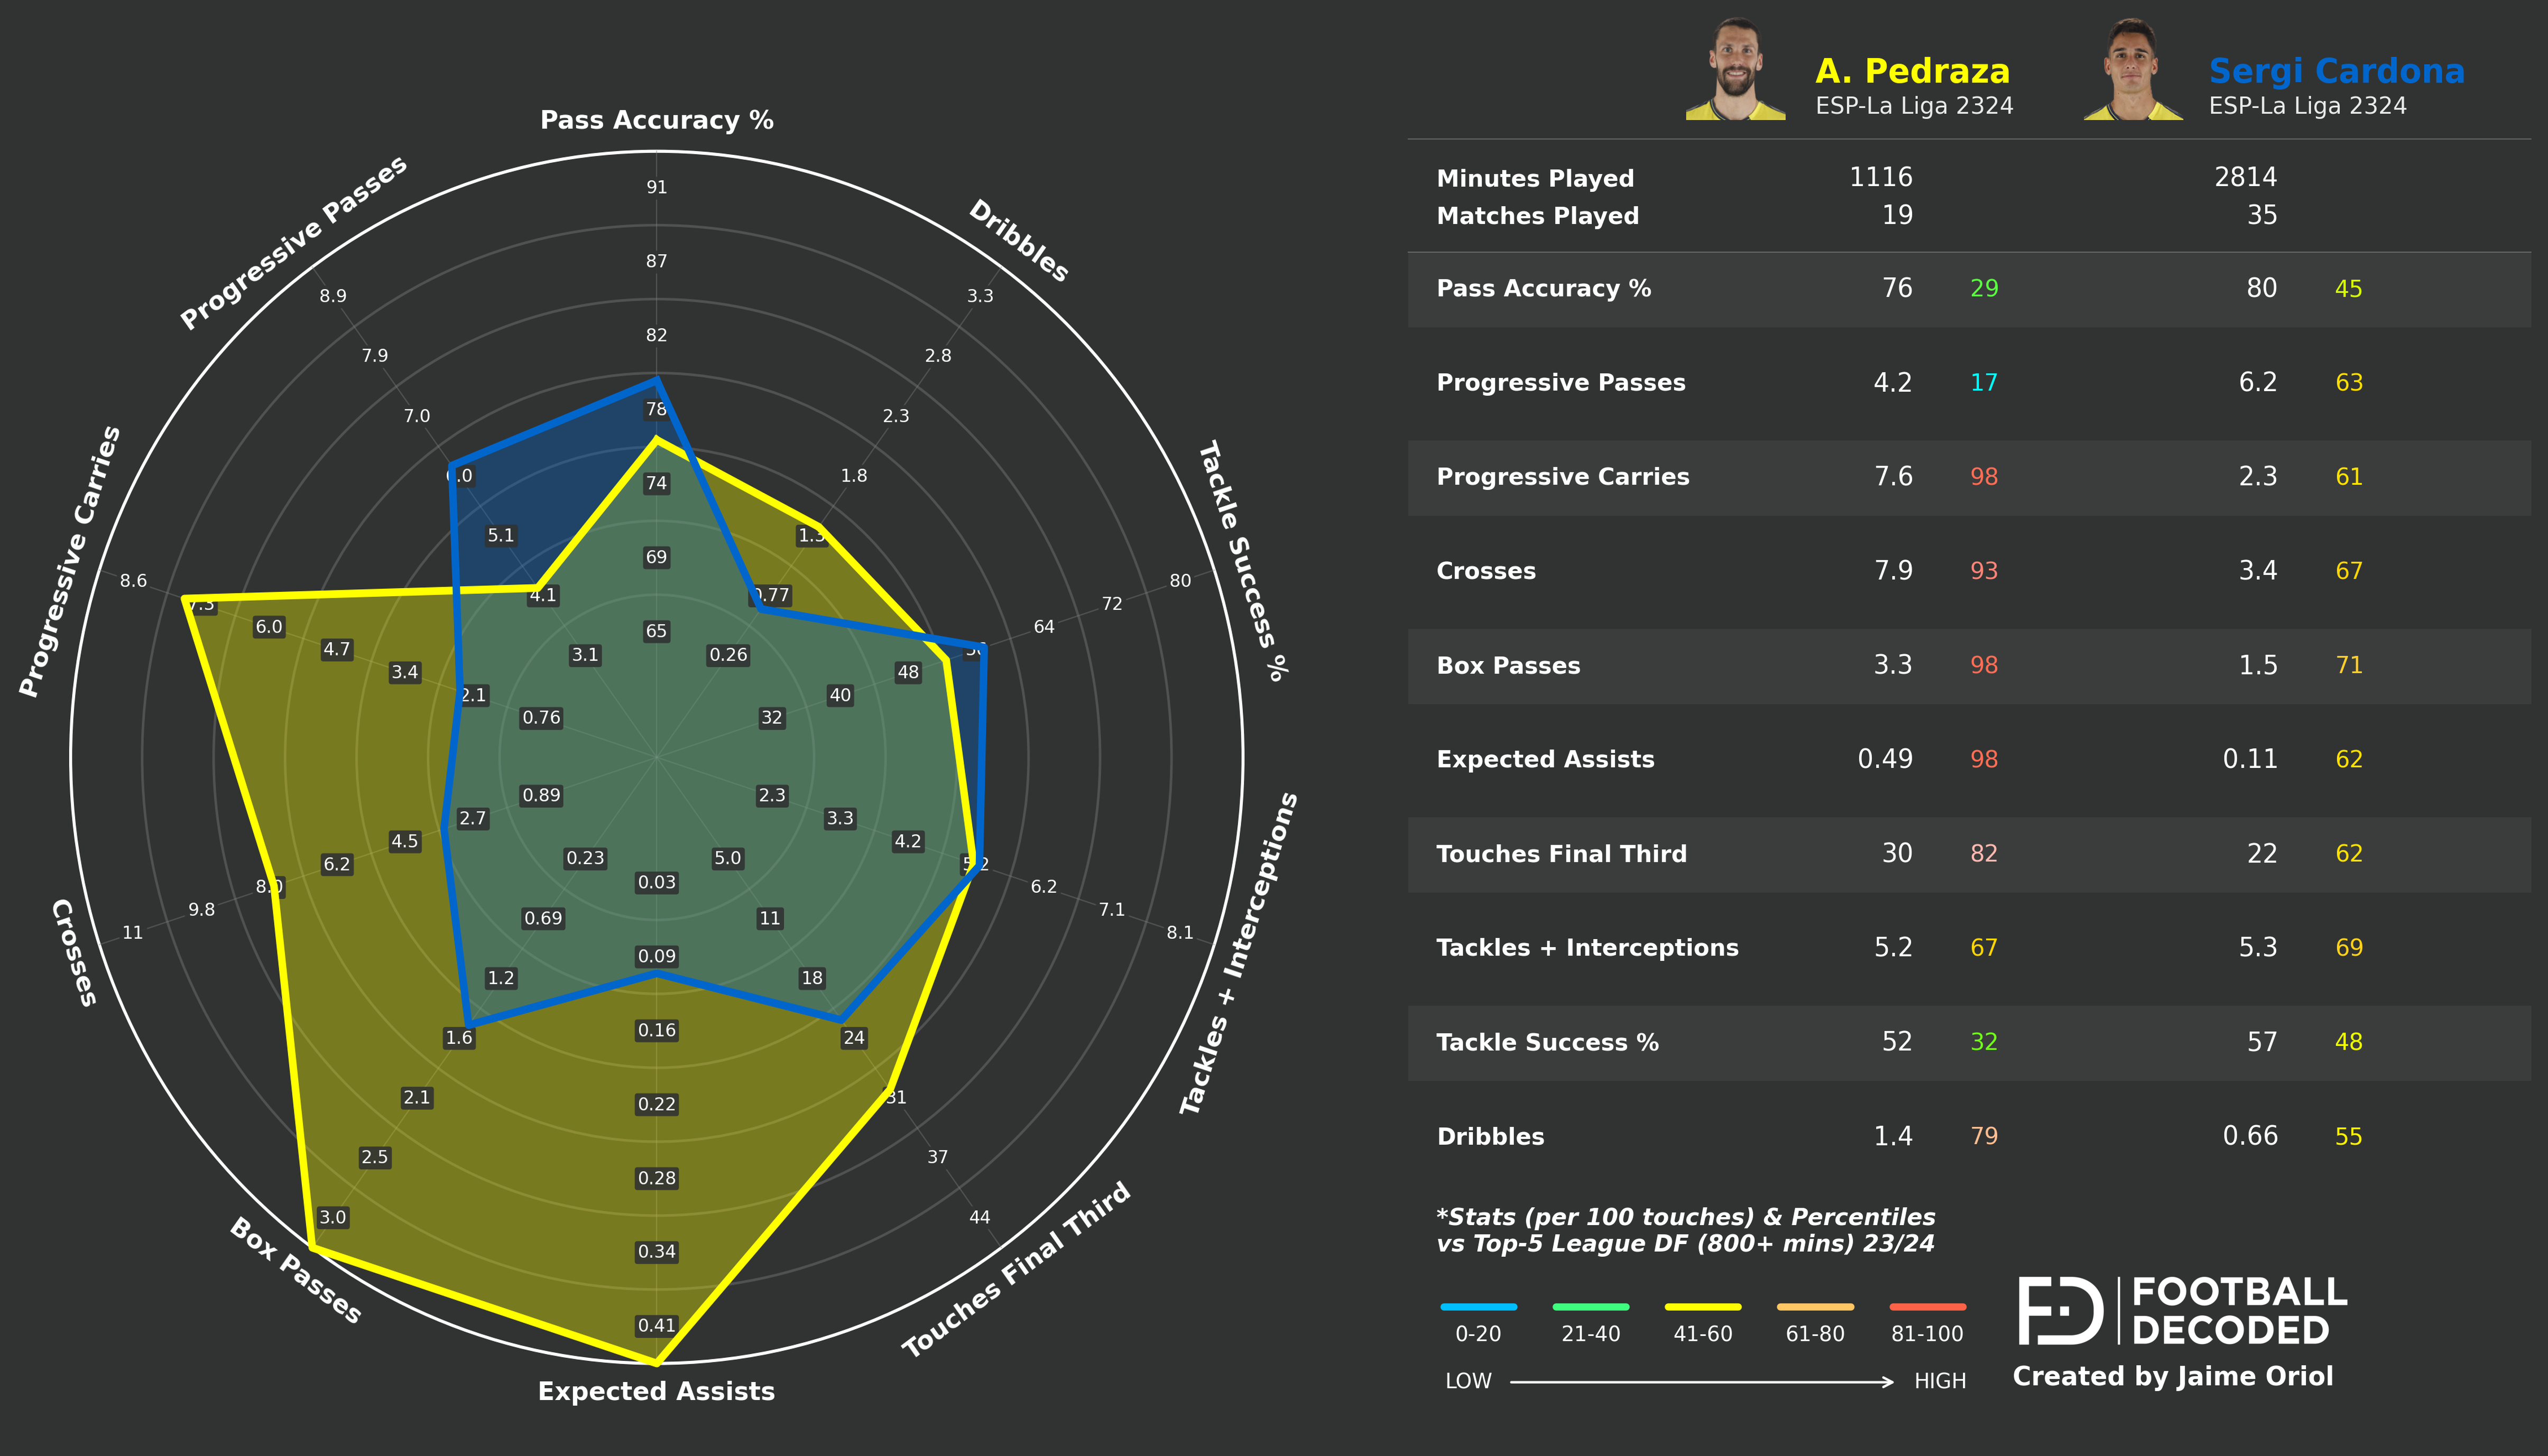


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./pedraza_cardona_radars/


In [14]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("DF LATERAL PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset DF
    position_df = df_final[df_final['position'].str.contains('DF', case=False, na=False)].copy()
    position_filter = "DF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches) & Percentiles\nvs Top-5 League {position_filter} ({MIN_MINUTES}+ mins) 23/24",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()